# Sample Offshore Precursor

In [1]:
# Load the modules
amrwindfedir = '/projects/wind_uq/lcheung/amrwind-frontend'         # official version
import sys, os
sys.path.insert(1, amrwindfedir)

# Load the libraries
import amrwind_frontend as amrwind
import matplotlib.pyplot    as plt
import numpy as np

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline


# Needed for headless mode
os.environ['DISPLAY']=':199'

In [2]:
# Start the case
case = amrwind.MyApp.init_nogui()

In [3]:
# Set the time constants
case.setAMRWindInput('time.stop_time', 50000.0)
case.setAMRWindInput('time.max_step',  -1)

case.setAMRWindInput('time.fixed_dt',  0.5)
case.setAMRWindInput('time.checkpoint_interval',  5000)

In [4]:
# Set some basic parameters
case.setAMRWindInput('incflo.physics',      ['ABL'])  # Must have ABL physics to do ABL calculations
case.setAMRWindInput('incflo.verbose',      3)        # This is optional, verbose=3 means more info in the output logs
case.setAMRWindInput('io.check_file',       'chk')    # What to name the checkpoint files

case.setAMRWindInput('incflo.use_godunov',  True)       # Always use a godunov scheme
case.setAMRWindInput('incflo.godunov_type', 'weno_z')   # Use 'weno_z' 

case.setAMRWindInput('turbulence.model',    ['OneEqKsgsM84'])    # One equation k-sgs subgrid scale model
case.setAMRWindInput('TKE.source_terms',    ['KsgsM84Src'])      # The corresponding source term

case.setAMRWindInput('transport.viscosity', 1.771e-05)           # dynamic viscosity, based on median air temperature of 284.47 K from 2 m above E06, units Pa-s
case.setAMRWindInput('incflo.density',      1.2456)                # density, based on 1017.13*100./(284.47)/287.058 where 1017.13 is median air pressure from 2 m above E06 and 284.47 is median air temperature from 2 m above E06, units kg/m^3

In [5]:
# Set the wind speed and direction
case.setAMRWindInput('useWSDir', True)                           # Allows you to specify wind speed + wind direction 
case.setAMRWindInput('ABL_windspeed', 9.0, forcechange=True)     # Wind speed, unites m/s VARY THIS
case.setAMRWindInput('ABL_winddir',   270, forcechange=True)     # Wind direction of 225 degrees, from S-W
case.ABL_calculateWindVector()

In [6]:
# Set some tolerances (leave this alone)
tols = """
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol                       = 1e-12               
mac_proj.mg_rtol                         = 1e-06               
mac_proj.mg_atol                         = 1e-12               
diffusion.mg_rtol                        = 1e-06               
diffusion.mg_atol                        = 1e-12               
temperature_diffusion.mg_rtol            = 1e-10               
temperature_diffusion.mg_atol            = 1e-13               
"""
case.loadAMRWindInput(tols, string=True);

In [7]:
# Sets up the domain and level 0 mesh
case.setAMRWindInput('geometry.prob_lo', [   0.0,    0.0, 0.0 ])
case.setAMRWindInput('geometry.prob_hi', [7200.0,  4000.0, 1440.0])   # each number must be divisible by 16
case.setAMRWindInput('amr.n_cell',       [720,     400,    144]) 

In [8]:
# This cell sets up boundary conditions
case.setAMRWindInput('is_periodicx', True)     # periodic in x
case.setAMRWindInput('is_periodicy', True)     # periodic in y
case.setAMRWindInput('is_periodicz', False)    # Enforce some boundary conditions in z

# Boundary conditions in z
case.setAMRWindInput('zlo.type',              'wall_model')          
case.setAMRWindInput('zlo.temperature_type',  'wall_model')          
case.setAMRWindInput('zlo.tke_type',          'zero_gradient')       
case.setAMRWindInput('zhi.type',              'slip_wall')           
case.setAMRWindInput('zhi.temperature_type',  'fixed_gradient')      
case.setAMRWindInput('zhi.temperature',       0.003) 

In [9]:
# Now set up ABL specific forces, parameters, etc.
case.setAMRWindInput('ICNS.source_terms',     ['ABLForcing','BoussinesqBuoyancy', 'CoriolisForcing', 'ABLMeanBoussinesq']) # ABLMeanBoussinesq: use this for production runs as you change from periodic boundaries to inflow/outflow boundaries

case.setAMRWindInput('ABL.stats_output_frequency',   1)           # Output ABL stats every iteration            
case.setAMRWindInput('ABL.stats_output_format',   'netcdf')       # Use netcdf output because that's how we postprocess

case.setAMRWindInput('ABLForcing.abl_forcing_height',   150)       # Hub height wind speed you want specify 
case.setAMRWindInput('ABL.kappa',                       0.4)      # Kolmogorov constant

case.setAMRWindInput('ABL.normal_direction',      2)              # vertical is in z
case.setAMRWindInput('ABL.surface_roughness_z0',  1.3e-3)           # Surface roughess, VARY THIS
case.setAMRWindInput('ABL.reference_temperature', 284.47)        # Median air temperature of 284.47 K from 2 m above E06, units K
case.setAMRWindInput('ABL.surface_temp_rate',      0.0)            # d(Temperature)/dt ---> set this to zero for unstable ABL, VARY THIS
case.setAMRWindInput('ABL.surface_temp_flux',      0.001)          # Surface temperature flux (K*m/s) --> Use this for unstable ABL's (ITERATE ON THIS TOO)

# Monin-Obukhov parameters (No need to change)
case.setAMRWindInput('ABL.mo_beta_m',             16.0)
case.setAMRWindInput('ABL.mo_gamma_m',            5.0)
case.setAMRWindInput('ABL.mo_gamma_h',            5.0)
case.setAMRWindInput('ABL.random_gauss_mean',     0.0)
case.setAMRWindInput('ABL.random_gauss_var',      1.0)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


In [10]:
case.setAMRWindInput('CoriolisForcing.latitude',  50.0)        # latitude of NE buoy: 39.97; latitude of SW buoy: 39.55, VARY THIS
case.setAMRWindInput('BoussinesqBuoyancy.reference_temperature', 284.47)    # The reference temperature, Median air temperature of 284.47 K from 2 m above E06, units K
# These inputs set up the initial temperature profile (Same as Nalu-Wind temperature profile)
case.setAMRWindInput('ABL.temperature_heights', '0       1200.0  1300.0  1460.0')
case.setAMRWindInput('ABL.temperature_values',  '284.47  284.47 292.47 292.95')

In [11]:
# This is a case where we don't want to use the defaults in amrwind-frontend
case.setAMRWindInput('ABL.perturb_velocity', True) # Ken added 12/8/2023
case.setAMRWindInput('ABL.perturb_ref_height', 50.0)
case.setAMRWindInput('ABL.Uperiods', 4.0)
case.setAMRWindInput('ABL.Vperiods', 4.0)
case.setAMRWindInput('ABL.deltaU',   1.0)
case.setAMRWindInput('ABL.deltaV',   1.0)
case.setAMRWindInput('ABL.perturb_temperature', True) # Ken added 12/8/2023
case.setAMRWindInput('ABL.theta_amplitude',   None)  # None: sets to default, which is 0.8 K
case.setAMRWindInput('ABL.cutoff_height',   None) # None: sets to default, which is 100 m

In [12]:
# To set up the sampling output
case.setAMRWindInput('time.plot_interval',        5000) 

## Set up some sampling planes
#case.setAMRWindInput('incflo.post_processing',    ['sampling'])            
#case.setAMRWindInput('sampling.output_frequency', 1)        
#case.setAMRWindInput('sampling.fields',           ['velocity', 'temperature'])

In [13]:
samplePlanePostPro = case.get_default_postprosetupdict()
samplePlanePostPro['postprocessing_setup_name'] = 'samplePlane_'
samplePlanePostPro['postprocessing_setup_type'] = 'Sampling'
samplePlanePostPro['postprocessing_setup_output_frequency'] =  1000
samplePlanePostPro['postprocessing_setup_fields']           =  ['velocity','tke']
case.add_postprosetup(samplePlanePostPro, verbose=True)

sampleplane = case.get_default_samplingdict()

sampleplane['sampling_outputto']     = 'samplePlane_'
sampleplane['sampling_name']         = 'p_hub'
sampleplane['sampling_type']         = 'PlaneSampler'
sampleplane['sampling_p_num_points'] = [241,134]
sampleplane['sampling_p_origin']     = [0, 0, 0]
sampleplane['sampling_p_axis1']      = [7200, 0, 0]
sampleplane['sampling_p_axis2']      = [0, 4000, 0]
sampleplane['sampling_p_normal']     = [0, 0, 1]      # This is the direction I want to move/offset the planes
sampleplane['sampling_p_offsets']    = '150'   # This is how much to offset the planes
case.add_sampling(sampleplane)

postprocessing_setup_name: 'samplePlane_'
postprocessing_setup_type: 'Sampling'
postprocessing_setup_output_frequency: 1000
postprocessing_setup_fields: ['velocity', 'tke']
postprocessing_setup_averaging_window: None
postprocessing_setup_averaging_start_time: None
postprocessing_setup_averaging_stop_time: None


In [14]:
# set up met masts
metmastpprosetup = case.get_default_postprosetupdict()
metmastpprosetup['postprocessing_setup_name'] = 'metmast_'
metmastpprosetup['postprocessing_setup_type'] = 'Sampling'
metmastpprosetup['postprocessing_setup_output_frequency'] =  1
metmastpprosetup['postprocessing_setup_fields']           =  ['velocity']
case.add_postprosetup(metmastpprosetup, verbose=True)

sampledict = case.get_default_samplingdict()
sampledict['sampling_name']     = 'metmast_T1'
sampledict['sampling_outputto'] = 'metmast_'
sampledict['sampling_type']     = 'LineSampler'
sampledict['sampling_l_num_points'] = 150
sampledict['sampling_l_start']      = [ 2160, 2000, 0]
sampledict['sampling_l_end']        = [ 2160, 2000, 0] + np.array([0, 0, 500])
case.add_sampling(sampledict, verbose=False)

postprocessing_setup_name: 'metmast_'
postprocessing_setup_type: 'Sampling'
postprocessing_setup_output_frequency: 1
postprocessing_setup_fields: ['velocity']
postprocessing_setup_averaging_window: None
postprocessing_setup_averaging_start_time: None
postprocessing_setup_averaging_stop_time: None


In [15]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     450,       450,      450,    91,    309,   center:specified units:meter centerx:640 centery:640 centerz:91 name:A
"""
#case.setAMRWindInput('refine_csvtextbox', refinementcsv)
#case.setAMRWindInput('refine_deleteprev', True)

In [16]:
#case.refine_createAllZones()
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxtagging'].getitemlist())

[]


## Plot the domain

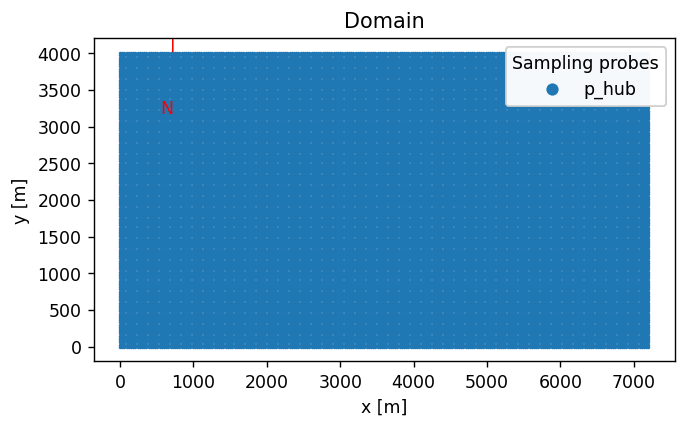

In [17]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['p_hub']
case.plotDomain(ax=ax)

Text(0.5, 1.0, 'Initial Temp. Profile')

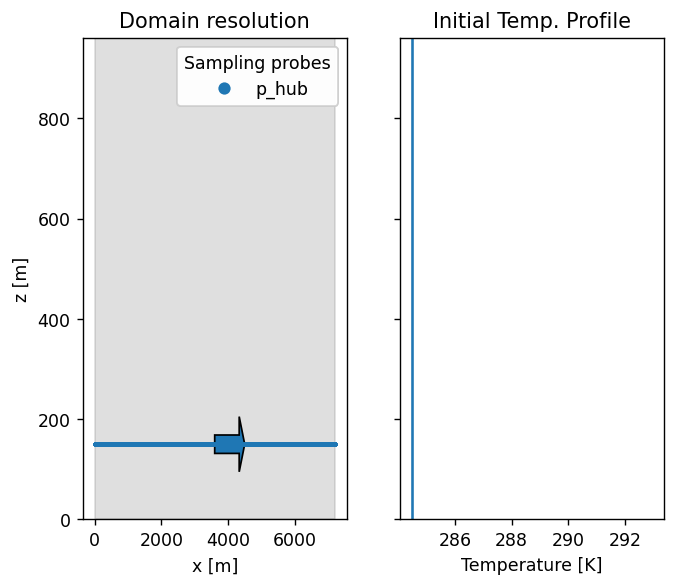

In [18]:
fig, axs = plt.subplots(1,2, figsize=(6,5), facecolor='w', dpi=125, sharey=True)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['p_hub']
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XZ' 
#case.popup_storteddata['plotdomain']['plot_refineboxes']     = ['box1', 'box2', 'box3'] 
case.plotDomain(ax=axs[0])
axs[0].set_title('Domain resolution')
axs[0].axis('auto')
axs[0].set_ylim([0,960])

case.plotGenericProfile('ABL.temperature_values', 'ABL.temperature_heights', ax=axs[1])
axs[1].set_ylim([0,960])
#axs[1].axis('scaled')
axs[1].set_xlabel('Temperature [K]')
axs[1].set_title('Initial Temp. Profile')

In [19]:
# This will print out your mesh size & refinements
case.estimateMeshSize()

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0     41472000             10.0 x 10.0 x 10.0
  TOTAL:     41472000


In [20]:
# Check that all inputs are okay
check=case.validate()

-- Checking inputs --
[ PASS] max_level:           max_level = 0 >= 0
[ PASS] dt & CFL:            DT and CFL OK
[ PASS] Actuator physics:    incflo.physics and ICNS.source_terms OK for Actuators
[ SKIP] Actuator FST:        No Actuators
[ SKIP] Sampling probes:     Not active or no sampling planes

Results: 
 3 PASS
 2 SKIP
 0 FAIL
 0 WARN


In [21]:
# Write the input file
#print(case.writeAMRWindInput('KingPlains_stable_precursor9_largerdomain.inp'))
print(case.writeAMRWindInput('Offshore_MedTI_Precursor_Coarse.inp'))

# --- Simulation time control parameters ---
time.stop_time                           = 50000.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.5                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 5000                
incflo.physics                           = ABL                 # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84        
TKE.source_terms                         = KsgsM84Src          
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol             

## Write a submission file (optional step)

In [22]:
# Set some of the submission script parameters
case.popup_storteddata['submitscript']['submitscript_numnodes'] = 48           
case.popup_storteddata['submitscript']['submitscript_runtime']  = '48:00:00'   # 48 hours
case.popup_storteddata['submitscript']['submitscript_wcid']     = 'fy230225'   # AWAKEN WCID
case.popup_storteddata['submitscript']['submitscript_partition']= 'batch'
case.popup_storteddata['submitscript']['submitscript_corespernode'] = 16       # 16 cores/node
case.popup_storteddata['submitscript']['submitscript_queue']    = 'normal'
case.popup_storteddata['submitscript']['submitscript_jobname']  = 'ABL0'       # name of the job

case.popup_storteddata['submitscript']['submitscript_filename'] = 'submit.sh'  # The name of your submission

In [23]:
# Preview what the submission script looks like
print(case.submitscript_makescript(case.savefile))

#!/bin/bash
#SBATCH --nodes=48
#SBATCH --time=48:00:00        # Wall clock time (HH:MM:SS) - once the job exceeds this time, the job will be terminated (default is 5 minutes)
#SBATCH --account=fy230225        # WC ID
#SBATCH --job-name=ABL0    # Name of job
#SBATCH --partition=batch # partition/queue name: short or batch
#SBATCH --qos=normal           # Quality of Service: long, large, priority or normal 
# Number of nodes - the number of nodes you have requested (for a list of SLURM environment variables see "man sbatch")
export nodes=$SLURM_JOB_NUM_NODES

module purge; module load cde/v3/gcc/10.3.0 cde/v3/openmpi/4.1.2-gcc-10.3.0 cde/v3/hdf5/1.10.6-gcc-10.3.0-openmpi-4.1.2 cde/v3/netcdf-c/4.8.1-gcc-10.3.0-openmpi-4.1.2 cde/v3/cmake/3.23.1

# Number MPI processes to run on each node (a.k.a. PPN)
# CTS1 has 36 cores per node and Ghost
#Chama has 16 cores per node
export cores=16
export ncpus=$((nodes * cores))
export OMP_PROC_BIND=spread 
export OMP_PLACES=threads

mpiexec --bind-to co

In [24]:
# This will write out submit.sh (and optionaly submit)
case.submitscript_savescript(submit=True)

Saved submit.sh
Executing: sbatch submit.sh
b'sbatch: INFO: Adding filesystem licenses to job: gpfs:1,nscratch:1,pscratch:1\nSubmitted batch job 32241924\n'
